In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

100%|██████████| 170M/170M [00:16<00:00, 10.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size

train_set, validation_set = torch.utils.data.random_split(train_dataset, [train_size, validation_size])

train_loader = torch.utils.data.DataLoader(train_set,batch_size=16, shuffle=True)

val_loader = torch.utils.data.DataLoader(validation_set,batch_size=16)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# CNN with Batch Normalization

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNN_BatchNorm(nn.Module):
    def __init__(self):
        super(CNN_BatchNorm, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        output = self.fc2(x)

        return output

# CNN without Batch Normalization

In [ ]:
class CNN_without_BatchNorm(nn.Module):
    def __init__(self):
        super(CNN_without_BatchNorm, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        output = self.fc2(x)

        return output

# CNN with Noisy BatchNorm

In [ ]:
class CNN_Noisy_BatchNorm(nn.Module):
    def __init__(self, n_mu=0.5, n_sigma=1.25, r_mu=0.1, r_sigma=0.1):
        super(CNN_Noisy_BatchNorm, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

        self.n_mu = n_mu
        self.n_sigma = n_sigma
        self.r_mu = r_mu
        self.r_sigma = r_sigma

    def add_noise(self, x):
        # Generate a random mean noise value (scalar) from a uniform distribution
        mu_t = torch.FloatTensor(1).uniform_(-self.n_mu, self.n_mu).to(x.device)
        # Generate a random standard deviation noise value (scalar) from a uniform distribution between
        sigma_t = torch.FloatTensor(1).uniform_(1, self.n_sigma).to(x.device)

        mu_t = mu_t.item()
        sigma_t = sigma_t.item()

        # Generate a noise tensor with the same shape as x where values are drawn from a uniform distribution with a mean of mu_t and a range of [mu_t - r_mu, mu_t + r_mu]
        m_t = torch.FloatTensor(x.size()).uniform_(mu_t - self.r_mu, mu_t + self.r_mu).to(x.device)
        # Generate a noise tensor with the same shape as x where values are drawn from a normal distribution with mean sigma_t and standard deviation r_sigma
        s_t = torch.FloatTensor(x.size()).normal_(sigma_t, self.r_sigma).to(x.device)

        # Return noisy form of x (activation)
        return s_t * x + m_t

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.add_noise(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.add_noise(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.add_noise(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        output = self.fc2(x)

        return output

# Retreive and Store gradients magnitude while training

In [ ]:
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_with_bn = CNN_BatchNorm().to(device)
model_without_bn = CNN_without_BatchNorm().to(device)
model_noisy_bn = CNN_Noisy_BatchNorm().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_with_bn = optim.SGD(model_with_bn.parameters(), lr=0.001, momentum=0.9)
optimizer_without_bn = optim.SGD(model_without_bn.parameters(), lr=0.001, momentum=0.9)
optimizer_noisy_bn = optim.SGD(model_noisy_bn.parameters(), lr=0.001, momentum=0.9)

n_epochs = 10

gradients_with_bn = []
gradients_without_bn = []
gradients_noisy_bn = []

def record_gradient_norms(model, gradient_list):
    for name, param in model.named_parameters():
        if param.grad is not None:
            gradient_list.append(param.grad.norm().item())

for epoch in range(n_epochs):
    model_with_bn.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer_with_bn.zero_grad()

        output = model_with_bn(data)
        loss = criterion(output, target)
        loss.backward()

        record_gradient_norms(model_with_bn, gradients_with_bn)

        optimizer_with_bn.step()

    model_without_bn.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer_without_bn.zero_grad()

        output2 = model_without_bn(data)
        loss2 = criterion(output2, target)
        loss2.backward()

        record_gradient_norms(model_without_bn, gradients_without_bn)

        optimizer_without_bn.step()


    model_noisy_bn.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer_noisy_bn.zero_grad()

        output3 = model_noisy_bn(data)
        loss3 = criterion(output3, target)
        loss3.backward()

        record_gradient_norms(model_noisy_bn, gradients_noisy_bn)

        optimizer_noisy_bn.step()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


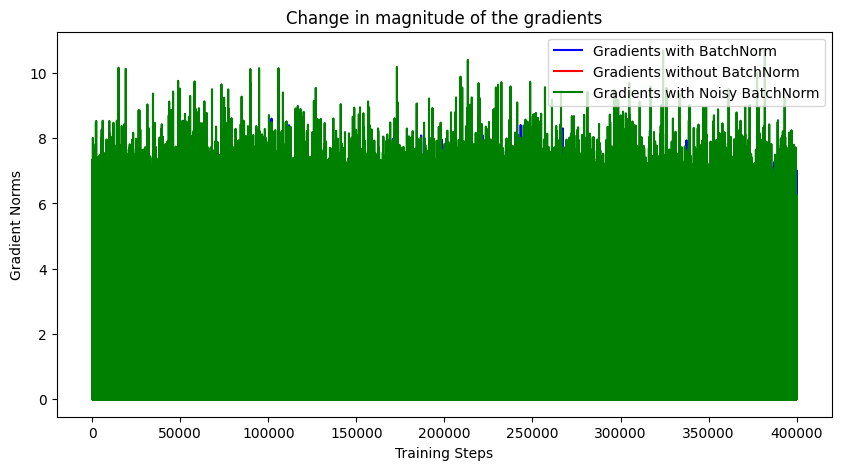

In [ ]:
def plot_gradient_norms(gradients_with_bn, gradients_without_bn, gradients_noisy_bn):

    plt.figure(figsize=(10, 5))
    plt.plot(gradients_with_bn, label='Gradients with BatchNorm', color='b')
    plt.plot(gradients_without_bn, label='Gradients without BatchNorm', color='r')
    plt.plot(gradients_noisy_bn, label='Gradients with Noisy BatchNorm', color='g')
    plt.xlabel('Training Steps')
    plt.ylabel('Gradient Norms')
    plt.title('Change in magnitude of the gradients')
    plt.legend()
    plt.show()

plot_gradient_norms(gradients_with_bn, gradients_without_bn, gradients_noisy_bn)

The graph is not easily interpretable. So, we will smooth out the gradients value by taking moving average.

For e.g [5, 20, 25, 10, 30, 20, 15]    ---->    (5 + 20) / 2 = 12.5  ,  (20 + 25) / 2 = 22.5 and so on.
The result becomes [12.5, 22.5, 17.5, 25, 25, 17.5]

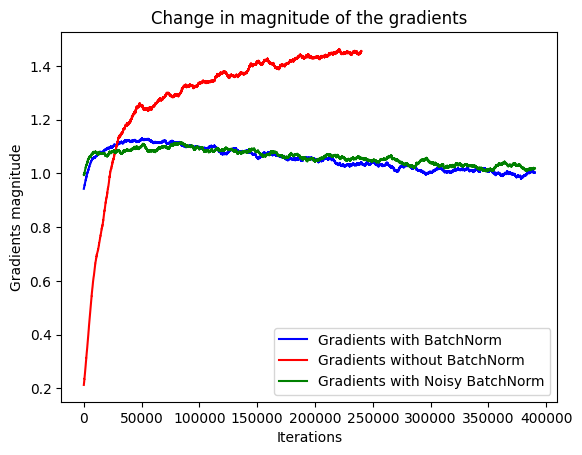

In [ ]:
def smooth(gradients, window_size=10000):
    return np.convolve(gradients, np.ones(window_size)/window_size, mode='valid')

smooth_grad_with_bn = smooth(gradients_with_bn)
smooth_grad_without_bn = smooth(gradients_without_bn)
smooth_grad_noisy_bn = smooth(gradients_noisy_bn)

plt.plot(smooth_grad_with_bn, label='Gradients with BatchNorm', color='b')
plt.plot(smooth_grad_without_bn, label='Gradients without BatchNorm', color='r')
plt.plot(smooth_grad_noisy_bn, label='Gradients with Noisy BatchNorm', color='g')
plt.xlabel('Iterations')
plt.ylabel('Gradients magnitude')
plt.title('Change in magnitude of the gradients')
plt.legend()
plt.show()